# Nonlinear classifiers
Try with nonlinear classifiers, can you do better than the models from above?

- Try with a random Forest, does increasing the number of trees help?
- Try with SVMs - does the RBF kernel perform better than the linear one?

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
import PIL.Image as Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X_tr = np.load('features_tr.npy')
y_tr = np.load('labels_tr.npy')

X_valid = np.load('features_valid.npy')
y_valid = np.load('labels_valid.npy')

X_test = np.load('features_test.npy')
y_test = np.load('labels_test.npy')

In [3]:
X_cv = np.concatenate((X_tr, X_valid), axis = 0)
y_cv = np.concatenate((y_tr, y_valid), axis = 0)

### Random Forest

In [4]:
rforest_pipe = Pipeline([
    ('scaler', None),
    ('pca', None),
    ('rforest', RandomForestClassifier(
                    n_estimators = 3, max_depth = 3, random_state = 0))
                ])
rforest_pipe.fit(X_tr, y_tr)
accuracy = rforest_pipe.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy))
accuracy

Accuracy: 0.760


0.76

I choose to apply PCA with n = 170 principal components.

In [5]:
rforest_pipe = Pipeline([
    ('scaler', None),
    ('pca', PCA(n_components = 170)),
    ('rforest', RandomForestClassifier(
                    n_estimators = 3, max_depth = 3, random_state = 0))
                ])
rforest_pipe.fit(X_tr, y_tr)
accuracy = rforest_pipe.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy))
accuracy

Accuracy: 0.480


0.48

As expected, increasing the number of estimators (decision trees) of the random forest to 300 the accuracy improves a lot.


In [6]:
rforest_pipe = Pipeline([
    ('scaler', None),
    ('pca', PCA(n_components = 170)),
    ('rforest', RandomForestClassifier(
                    n_estimators = 300, max_depth = 3, random_state = 0))
                ])
rforest_pipe.fit(X_tr, y_tr)
accuracy = rforest_pipe.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy))
accuracy

Accuracy: 0.800


0.8

I will now tune the random forest clasifier in order to

In [7]:
rforest_pipe = Pipeline([
    ('scaler', None),
    ('pca', None),
    ('rforest', RandomForestClassifier(
                    max_depth = 3, random_state = 0))
                ])

In [8]:
grid = { 'rforest__n_estimators': np.arange(1,300,10) }

grid_cv = GridSearchCV(rforest_pipe, grid, cv = 5, return_train_score = True, verbose = 1, n_jobs = -1)
grid_cv.fit(X_cv, y_cv)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   19.7s finished
/Users/tgdstpej/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('pca', None), ('rforest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
    ...rs='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'rforest__n_estimators': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
       261, 271, 281, 291])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [9]:
grid_cv.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', None), ('pca', None), ('rforest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [10]:
accuracy_rf = grid_cv.score(X_test, y_test)
accuracy_rf

0.86

In [11]:
results_rf = { 'model': ['random_forest'], 'accuracy' : [accuracy_rf] }
results_rf = pd.DataFrame(results_rf)
np.save('results_rf', results_rf)
results_rf

,model,accuracy
0,random_forest,0.86


In [12]:
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_rforest__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [13]:
cv_results = pd.DataFrame(grid_cv.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_rforest__n_estimators']
cv_results[cols].sort_values(by = 'mean_test_score', ascending = False)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_rforest__n_estimators
2,0.842482,0.025710,0.861582,0.009986,21
4,0.828162,0.022431,0.863351,0.009090,41
3,0.823389,0.019217,0.852626,0.008511,31
5,0.823389,0.022810,0.864552,0.008820,51
6,0.821002,0.017625,0.860411,0.008253,61
12,0.816229,0.014558,0.861597,0.008353,121
11,0.816229,0.014558,0.863406,0.009977,111
10,0.816229,0.014558,0.861583,0.006740,101
21,0.813842,0.016280,0.856226,0.009330,211
26,0.813842,0.016475,0.859198,0.006657,261


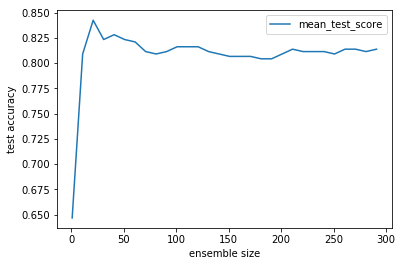

In [14]:
plt.plot(cv_results['param_rforest__n_estimators'], cv_results['mean_test_score'])
plt.legend()
plt.xlabel('ensemble size')
plt.ylabel('test accuracy')
plt.show()

Increasing the number of ensemble size, the accuracy increases lineary until some threshold or peak value (in this case for 21 ensemble size) and then it saturates to a value slightly less than the peak. 

#### Question: should we use label encoding for y?

### SVM (Support Vector Machines)



a first run without optimization

In [15]:
from sklearn.svm import SVC

svm_rbf_pipe = Pipeline([
    ('scaler', None),
    ('pca', PCA(n_components = 170)),
    ('svm_rbf', SVC(kernel = 'rbf', C = 0.1, gamma = 0.01))
                ])
svm_rbf_pipe.fit(X_tr, y_tr)
accuracy_rbf = svm_rbf_pipe.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy_rbf))
accuracy_rbf

Accuracy: 0.760


0.76

In [16]:
results_svm_rbf = { 'model': ['svm_rbf'], 'accuracy' : [accuracy_rbf] }
results_svm_rbf = pd.DataFrame(results_svm_rbf)
np.save('results_svm_rbf', results_svm_rbf)
results_svm_rbf

,model,accuracy
0,svm_rbf,0.76


I will perform grid search to understand which one is better.

In [17]:
grid = { 'svm_rbf__kernel': ['rbf', 'linear'],
           'svm_rbf__C': np.logspace(-4, 4, num = 30),
           'svm_rbf__gamma': np.arange(0.1, 200.1, 10)
       }

grid_cv = GridSearchCV(svm_rbf_pipe, grid, cv = 5, return_train_score = True, verbose = 1, n_jobs = -1)
grid_cv.fit(X_cv, y_cv)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  9.1min finished
/Users/tgdstpej/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('pca', PCA(copy=True, iterated_power='auto', n_components=170, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svm_rbf', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svm_rbf__kernel': ['rbf', 'linear'], 'svm_rbf__C': array([1.00000e-04, 1.88739e-04, 3.56225e-04, 6.72336e-04, 1.26896e-03,
       2.39503e-03, 4.52035e-03, 8.53168e-03, 1.61026e-02, 3.03920e-02,
       5.73615e-02, 1.08264e-01, 2.04336e-01, 3.85662e-01, 7.27895e-01,
       1.37382e+00, ...    1.201e+02, 1.301e+02, 1.401e+02, 1.501e+02, 1.601e+02, 1.701e+02,
       1.801e+02, 1.901e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_t

In [18]:
grid_cv.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', None), ('pca', PCA(copy=True, iterated_power='auto', n_components=170, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svm_rbf', SVC(C=0.008531678524172805, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=80.1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [19]:
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_svm_rbf__C', 'param_svm_rbf__gamma', 'param_svm_rbf__kernel', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [20]:
cv_results = pd.DataFrame(grid_cv.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_svm_rbf__C', 'param_svm_rbf__gamma', 'param_svm_rbf__kernel']
cv_results[cols].sort_values(by = 'mean_test_score', ascending = False)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_svm_rbf__C,param_svm_rbf__gamma,param_svm_rbf__kernel
297,0.945107,0.015288,0.980918,0.004016,0.00853168,80.1,linear
301,0.945107,0.015288,0.981522,0.003397,0.00853168,100.1,linear
317,0.942721,0.012841,0.980326,0.003994,0.00853168,180.1,linear
307,0.942721,0.012841,0.980325,0.004421,0.00853168,130.1,linear
323,0.942721,0.017962,0.989861,0.003042,0.0161026,10.1,linear
315,0.942721,0.012841,0.980319,0.004451,0.00853168,170.1,linear
289,0.942721,0.012841,0.980923,0.004409,0.00853168,40.1,linear
287,0.942721,0.012841,0.980918,0.004016,0.00853168,30.1,linear
309,0.942721,0.012841,0.980925,0.003981,0.00853168,140.1,linear
281,0.942721,0.012841,0.980325,0.004421,0.00853168,0.1,linear


In [21]:
accuracy_linear = grid_cv.score(X_test, y_test)
accuracy_linear

0.94

In [22]:
results_svm_linear = { 'model': ['svm_linear'], 'accuracy' : [accuracy_linear] }
results_svm_linear = pd.DataFrame(results_svm_linear)
np.save('results_svm_linear', results_svm_linear)
results_svm_linear

,model,accuracy
0,svm_linear,0.94


In [23]:
cv_results[cv_results['param_svm_rbf__kernel'] == 'rbf'].sort_values(by = 'mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm_rbf__C,param_svm_rbf__gamma,param_svm_rbf__kernel,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1000,0.492684,0.033206,0.015944,0.001214,788.046,0.1,rbf,"{'svm_rbf__C': 788.0462815669904, 'svm_rbf__ga...",0.436782,0.482353,...,0.503580,0.049346,581,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
720,0.805832,0.079423,0.013623,0.000829,9.23671,0.1,rbf,"{'svm_rbf__C': 9.236708571873866, 'svm_rbf__ga...",0.436782,0.494118,...,0.501193,0.048004,582,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1040,0.492144,0.027570,0.013281,0.001782,1487.35,0.1,rbf,"{'svm_rbf__C': 1487.3521072935118, 'svm_rbf__g...",0.436782,0.482353,...,0.498807,0.047452,583,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1080,0.602393,0.027082,0.015310,0.001328,2807.22,0.1,rbf,"{'svm_rbf__C': 2807.2162039411755, 'svm_rbf__g...",0.436782,0.482353,...,0.496420,0.044549,584,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
800,0.476027,0.024337,0.014938,0.003354,32.9034,0.1,rbf,"{'svm_rbf__C': 32.90344562312671, 'svm_rbf__ga...",0.436782,0.482353,...,0.496420,0.045129,584,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
960,0.593389,0.041436,0.017207,0.002183,417.532,0.1,rbf,"{'svm_rbf__C': 417.53189365604004, 'svm_rbf__g...",0.436782,0.482353,...,0.496420,0.050259,584,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1160,0.714979,0.028596,0.022125,0.002904,10000,0.1,rbf,"{'svm_rbf__C': 10000.0, 'svm_rbf__gamma': 0.1,...",0.436782,0.482353,...,0.496420,0.044549,584,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
600,0.639356,0.049447,0.018506,0.003095,1.37382,0.1,rbf,"{'svm_rbf__C': 1.3738237958832638, 'svm_rbf__g...",0.436782,0.482353,...,0.494033,0.041930,588,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
640,0.721470,0.024384,0.017707,0.002685,2.59294,0.1,rbf,"{'svm_rbf__C': 2.592943797404667, 'svm_rbf__ga...",0.436782,0.482353,...,0.494033,0.046804,588,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1120,0.660999,0.021362,0.015301,0.001140,5298.32,0.1,rbf,"{'svm_rbf__C': 5298.316906283702, 'svm_rbf__ga...",0.436782,0.482353,...,0.494033,0.046245,588,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [24]:
accuracy_linear = grid_cv.score(X_test, y_test)
accuracy_linear

0.94

In [25]:
results_svm_linear = { 'model': ['svm_linear'], 'accuracy' : [accuracy_linear] }
results_svm_linear = pd.DataFrame(results_svm_linear)
np.save('results_svm_linear', results_svm_linear)
results_svm_linear

,model,accuracy
0,svm_linear,0.94


In [26]:
from sklearn.svm import SVC

svm_rbf_pipe = Pipeline([
    ('scaler', None),
    ('pca', PCA(n_components = 170)),
    ('svm_rbf', SVC(kernel = 'rbf', C = 1.37382, gamma = 0.1))
                ])
svm_rbf_pipe.fit(X_tr, y_tr)
accuracy_rbf = svm_rbf_pipe.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy_rbf))
accuracy_rbf

Accuracy: 0.360


0.36

In [27]:
from sklearn.svm import SVC

svm_rbf_pipe = Pipeline([
    ('scaler', None),
    ('pca', PCA(n_components = 170)),
    ('svm_rbf', SVC(kernel = 'rbf', C = 0.1, gamma = 0.01))
                ])
svm_rbf_pipe.fit(X_tr, y_tr)
accuracy_rbf = svm_rbf_pipe.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy_rbf))
accuracy_rbf

Accuracy: 0.760


0.76

In [28]:
results_svm_rbf = { 'model': ['svm_rbf'], 'accuracy' : [accuracy_rbf] }
results_svm_rbf = pd.DataFrame(results_svm_rbf)
np.save('results_svm_rbf', results_svm_rbf)
results_svm_rbf

,model,accuracy
0,svm_rbf,0.76


The best accuracy is achieved with the linear kernel. 